# Lattice Models

A number of physical systems can be modelled using a discrete (2D) lattice with periodic boundary conditions. My final year group project at KCL was one such example: we looked at the self-assembly/bonding of (hexagonal) borazine molecules on a surface (metal substrate). 

Computationally, the state of such a system can represented quite naturally as an array with the relevant dimensions. The system geometry/topology can then be imposed by specifying a rule giving the neighbours of each element - clearly a square lattice can be easily represented as an array but other periodic structures (e.g. hexagonal) can easily be represented with slight modification of the rule identifying neighbouring elements. 

This system lends itself to a class heirarchy with a superclass (Lattice) providing an interface, with each geometry instatiated as a subclass.

In [1]:
import numpy as np


class Lattice:

    def __init__(self, n, m):
        """ Superclass for Lattice objects.

        This class provides an interface. A subclass should contain a
        neighbours(self, i, j) function defining the neighbouring points
        (their indices) to point (i, j). This defines the lattice geometry.

        The subclass constructor should also define the number of neighbours at
        each point.

        Args:
            n (int): linear size in y dimension
            m (int): linear size in x dimension

        """
        self.n = n
        self.m = m
        self.generate_neighbour_list()

    def single_to_double_index(self, k):
        """ Convert single to double index.

        Args:
            k (int): single index for array element

        Returns:
            i, j: corresponding double index for array element

        """
        return (k // self.m), np.mod(k, self.m)

    def double_to_single_index(self, i, j):
        """ Convert double to single index

        Args:
            i, j: double index for array element

        Returns:
            k (int): single index for array element

        """
        k = (i * self.n) + j
        return k

    def neighbours(self, i, j):
        """Must be implemented in the subclass used.

        See examples in subclasses HexLattice and SquareLattice.

        Raises:
            NotImplementedError: If subclass does not have such a method

        """
        raise NotImplementedError(
            'nearest neighbours function missing in class %s'
            % self.__class__.__name__)

    def generate_neighbour_list(self):
        """Generate an array of neighbours.

        self.neighbour_list[i, j, p, :] = a, b, where
        a, b = double indexed coordinates of pth neighbour of site (i, j)

        """

        n, m = self.n, self.m
        neighbour_list = np.zeros(
            [n, m, self.n_neighbours, 2], dtype=np.int)

        for s in range(n * m):
            i, j = self.single_to_double_index(s)
            nn = self.neighbours(i, j)
            neighbour_list[i, j, :, :] = nn
        self.neighbour_list = neighbour_list


All subclass instances require an attribute specifying the number of neighbours (at each point) and a method defining neighbouring elements of each array element. The superclass can then generate an array specifying all neighbours for each array element - with large Monte Carlo simulations this is more efficient than calling the neighbours method at each step.

I have included classes for both a square (good for the Ising model) and hexagonal (good for my borazines project).

In [2]:
class HexLattice(Lattice):

    def __init__(self, n, m):
        """ AKA Triangular lattice. Each point has siz neighbours.

        The unit tile is a rhombus.

        Args:
            n (int): linear size (0 axis)
            m (int): linear size (1 axis)

        """
        self.n_neighbours = 6
        super().__init__(n, m)

    def neighbours(self, i, j):
        """Nearest neighbouring sites.

         This function defines a hexagonal lattice:
                X X
              X 0 X
              X X

        Args:
            i, j (int): the original lattice site

        Returns:
             nn (ndarray): array with entries corresponding to the six nearest
             neighbours of the given lattice site"""
        n = self.n
        m = self.m
        nn = np.zeros([6, 2], dtype=np.int)

        # order: top, top right, left, right, bottom left
        nn[0, :] = np.mod(i + 1, n), j
        nn[1, :] = np.mod(i + 1, n), np.mod(j + 1, m)
        nn[2, :] = i, np.mod(j - 1 + m, m)
        nn[3, :] = i, np.mod(j + 1, m)
        nn[4, :] = np.mod(i - 1 + n, n), np.mod(j - 1 + m, m)
        nn[5, :] = np.mod(i - 1 + n, n), j

        return nn


class SquareLattice(Lattice):
    def __init__(self, n, m):
        """Von Neumann Neighbourhood

        Args:
            n (int): linear size in y dimension
            m (int): linear size in x dimension

        """
        self.n_neighbours = 4
        super().__init__(n, m)

    def neighbours(self, i, j):
        """Nearest neighbouring sites (von Neumnann neighbourhood)


        This function defines a square lattice:
              X
            X 0 X
              X

        Args:
            i, j (int): the original lattice site

        Returns:
             nn (ndarray): array with entries corresponding to the four nearest
             neighbours of the given lattice site

        """
        n = self.n
        m = self.m
        nn = np.zeros([4, 2], dtype=np.int)

        # order: top, left, right, bottom
        nn[0, :] = np.mod(i + 1, n), j
        nn[1, :] = i, np.mod(j - 1 + m, m)
        nn[2, :] = i, np.mod(j + 1, m)
        nn[3, :] = np.mod(i - 1 + n, n), j

        return nn


With the above in place, a number of models can easily be constructed.

# Self-assembly of supported borazine molecules

Self assembly has important applications in biology and nanotechnology. Theoretical approaches often rely heavily on computer simulations due to the intrinsic complexity of systems with many interacting elements. My third year project (Physics, KCL) looked at the van der Waals interaction of borazine molecules on a surface (at thermal equilibrium) using a Metropolis Monte Carlo simulation. We were given code to work with but I decided to write my own. 

The system is represented as an array, with a discrete state-space for each lattice site (each element takes on a value of 1 if the site is occupied, 0 if unoccupied). A model is initialised with a fixed number of molecules (representing a particular fractional coverage of the substrate surface) and evolved using the Metropolis algorithm. Short range van der Waals (attractive) forces are represented via the energy term, which at its simplest can be taken to be negative and proportional to the number of 'bonds' between molecules (shared edges between occupied lattice sites). This is in many ways the simplest possible such model, but is enough to explore the trade-off between energy and entropy considerations relevant to bonding, and aggregation phenomena including Ostwald ripening. 

The class below can easily be extended to allow for more complex interactions, including Coulomb forces, by changing the energy associated with a given model state.

The model class defines some extra lattice functionality (checking for bonds between molecules = occupied array sites) and a simple implementation of the Metropolis algorithm for the relevant energy calculations. With such a simple term for the energy there is little pressure towards greater modularisation but I would like to (eventually) refactor the code for more flexibility. 

In [3]:
import matplotlib.pyplot as plt
import random


class SubstrateBonding2D:

    def __init__(self, n, m, x, vdW, kT, lattice_type):
        """Simulates self-assembly of borazine molecules on a surface.

        Metropolis Monte Carlo algorithm.

        Args:
            n (int): unit cell size (dimension 0)
            m (int): unit cell size (dimension 1)
            x (int): number of molecules
            vdW: molecular bond strength (molecules bond if they share an edge)
            kT: Temperature
            lattice_type: Lattice object (recommended = HexLattice)

        """
        self.n, self.m = n, m
        self.lattice = lattice_type(n, m)
        self.x = x
        self.vdW = vdW
        self.kT = kT
        self.initialise_system()

    def initialise_system(self):
        """Initialise with self.x (randomly chosen) occupied sites."""
        state0 = np.zeros([self.n, self.m], dtype=int)
        perm = np.random.permutation(self.n * self.m)
        for i in range(self.x):
            a, b = self.lattice.single_to_double_index(perm[i])
            state0[a, b] = 1
        self.state = state0

    def indexfinder(self, arr, site_state):
        """Given an occupation array, returns a list of occupied sites.

        Args:
            arr (ndarray): lattice state
            site_state (int): site state

        Returns (list): indexes of sites in arr satisfying site==site_state

        """
        sites = []
        for i, row in enumerate(arr):
            for j, x in enumerate(row):
                if x == site_state:
                    sites.append((i, j))
        return sites

    def bond_finder(self, site1, site2):
        """Checks whether two sites share an edge"""
        i, j = site1
        bonds = 0
        for neighbour in self.lattice.neighbour_list[i, j, :, :]:
            if neighbour[0] == site2[0] and neighbour[1] == site2[1]:
                bonds += 1
        return bonds

    def new_site(self, site):
        """Checks potential lattice sites until it finds an unoccupied one"""
        perm = np.random.permutation(self.n * self.m)
        newsite = site
        for i in range(self.n * self.m):
            p, q = self.lattice.single_to_double_index(perm[i])
            if self.state[p, q] == 0:
                newsite = (p, q)
                break
        return newsite

    def count_bonds(self, occ_sites):
        """ Counts bonds in a given lattice state (relevant for energy calculation).

        Args:
            occ_sites: list of double-indexed occupied sites

        Returns: number of shared edges (bonds)

        """
        n_bonds = 0
        for i in range(len(occ_sites)):
            for j in range(i + 1, len(occ_sites)):
                n_bonds += self.bond_finder(occ_sites[i], occ_sites[j])
        return n_bonds

    def metropolis_update(self):
        """Single step of Metropolis Monte Carlo algorithm

        Pick a single occupied lattice site: move to an unoccupied site if
        energetically favourable (or due to thermal fluctuation)

        """
        kT, vdW = self.kT, self.vdW

        trial_site = random.sample(self.occupied, 1)[0]  # monomer that we might move
        fixed_sites = []
        for site in self.occupied:
            if site != trial_site:
                fixed_sites.append(site)  # other monomers

        # find a new unoccupied site to move to
        candidate = self.new_site(trial_site)
        trial_occupied = fixed_sites
        trial_occupied.append(candidate)

        E_0 = - vdW * self.bonds
        E_1 = - vdW * self.count_bonds(trial_occupied)
        delta_E = E_1 - E_0

        # flip if energetically favourable, or due to thermal fluctuation
        if np.random.random() < np.exp(-delta_E / kT):
            self.state[trial_site] = 0
            self.state[candidate] = 1
            self.bonds = self.count_bonds(trial_occupied)
            self.occupied = trial_occupied

    def run_sim(self, mc_steps, verbose=True):
        """Run Metropolis MC simulation for specified number of steps

        Args:
            mc_steps (int): number of Monte Carlo steps per sim
            verbose (bool): if True, print simulation parameters

        Returns:
             bonds_ls: list with the number of bonds at each MC step.

        """
        n, m, kT, vdW = self.n, self.m, self.kT, self.vdW

        # Initial bond count (to calculate energy)
        self.occupied = self.indexfinder(self.state, 1)
        self.bonds = self.count_bonds(self.occupied)

        bonds_ls = []
        bonds_ls.append(self.bonds)

        for t in range(mc_steps):
            self.metropolis_update()
            bonds_ls.append(self.bonds)

        if verbose == True:
            coverage = self.x / (n * m)
            print('\nSimulation complete')
            print('n, m, coverage, vdW, kT, mc_steps')
            print(n, m, coverage, vdW, kT, mc_steps)

        return bonds_ls  # number of bonds at each MC step



For simple systems (up to three molecules) we can easily derive the equilibrium conditions. With two molecules, we can model the system as a canonical ensemble: the predicted ratio of probabilities ('bond ratio') for the two different configurations is given by

$$ \frac{P_{bonded}}{P_{unbonded}} = \frac{6}{nm - 7} \exp(E_{vdW}  /  k_B T) $$

where $n \times m$ is the system size.

The entropy terms (relative likelihood of different bonding configurations independent of energy considerations) represent hard combinatoric problems, so even with far fewer than ten molecules, Monte Carlo is the way to go. 

An example given in borazines_bonding.py looks at the temperature dependence on bonding for three molecules on a 10x10 hexagonal 'unit cell' - each 10x10 simulation of 10,000 steps takes around one second to complete, so reliably exploring the parameter space of even such a simple model can take several hours. 


Simulation complete
n, m, coverage, vdW, kT, mc_steps
10 10 0.02 0.06 0.012 10000

Simulation complete
n, m, coverage, vdW, kT, mc_steps
10 10 0.02 0.06 0.0134 10000

Simulation complete
n, m, coverage, vdW, kT, mc_steps
10 10 0.02 0.06 0.0148 10000

Simulation complete
n, m, coverage, vdW, kT, mc_steps
10 10 0.02 0.06 0.0162 10000

Simulation complete
n, m, coverage, vdW, kT, mc_steps
10 10 0.02 0.06 0.0176 10000

Simulation complete
n, m, coverage, vdW, kT, mc_steps
10 10 0.02 0.06 0.019 10000

Simulation complete
n, m, coverage, vdW, kT, mc_steps
10 10 0.02 0.06 0.0204 10000

Simulation complete
n, m, coverage, vdW, kT, mc_steps
10 10 0.02 0.06 0.0218 10000

Simulation complete
n, m, coverage, vdW, kT, mc_steps
10 10 0.02 0.06 0.0232 10000

Simulation complete
n, m, coverage, vdW, kT, mc_steps
10 10 0.02 0.06 0.0246 10000

Simulation complete
n, m, coverage, vdW, kT, mc_steps
10 10 0.02 0.06 0.026 10000


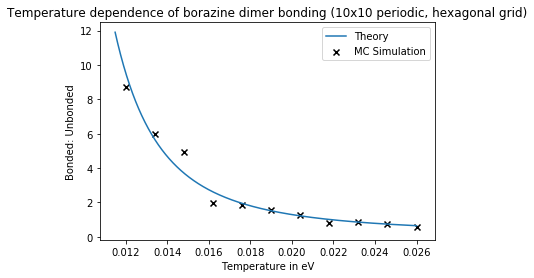

In [4]:
# Example

n, m = 10, 10   # 10 x 10 unit tile for hexagonal lattice
x = 2           # dimer (two borazine molecules)
vdW = 0.06      # borazine vdW bond strength (per bond) in eV
mc_steps = 10000

kT_list = np.linspace(0.012, 0.026, 11)   # ~139 K to 302 K

bond_ratio = []
for kT in kT_list:
    model = SubstrateBonding2D(n, m, x, vdW, kT, HexLattice)
    bonds = model.run_sim(mc_steps, verbose=True)
    bond_ratio.append(np.sum(bonds) / (mc_steps - np.sum(bonds)))
    
def predicted_ratio(E, T, size):
    return (6 / (size - 7)) * np.exp(E / T)

mesh = np.linspace(0.0115, 0.026, 1000)
predicted = [predicted_ratio(vdW, temp, n*m) for temp in mesh]

plt.plot(mesh, predicted, label='Theory')
plt.scatter(kT_list, bond_ratio, marker = 'x', c='black', label='MC Simulation')
plt.legend(loc='upper right')
plt.xlabel('Temperature in eV')
plt.ylabel('Bonded: Unbonded')
plt.title('Temperature dependence of borazine dimer bonding (10x10 periodic, hexagonal grid)')
plt.show()

# The Ising Model 

The Ising Model is a model of magnetism in statistical mechanics, with discrete magnetic moments (spins) on a lattice. The model can be solved exactly in one or two (but not three) dimensions. 

Each spin contributes to the total energy via its interactions with other spins and the external field. In the simplest model, there is no external magnetic field, and only nearest neighbour spin interactions are considered when calculating the energy of a particular configuration. Interactions between spins can be either ferromagentic (energetically favourable for spins to align) or antiferromagnetic (energetically favourable for spins to orient antiparallel to their neighbours). 

There are three possible regular lattice geometries in 2D: square, triangular and hexagonal, with a square lattice the easiest to model. In particular, triangular / hexagonal lattices are interesting when the interaction is antiferromagnetic: some frustration is always inevitable, whereas on a square lattice a 'chessboard' configuration with no frustration is possible. 

The model uses Monte Carlo simulation to equilibrate the system - equilibrium properties can then be calculated. The Metropolis algorithm is perhaps the simplest such method: at each monte carlo step, a spin is selected at random and flipped: (a) with probability 1 if the flip is energetically favourable or (b) with some probability dependent on the parameters of the model, corresponding to a thermal fluctuation, if the flip is energetically unfavourable. 

This method slows down close to equilibrium, as fewer spins lie at the boundaries of domains and flips become less likely (see Metropolis.gif). The Wolff Cluster method is far more efficient: at each Monte Carlo step, a cluster of aligned spins (in the ferromagnetic case) is found/constructed, then flipped. This enables much faster equilibration. 

N.B.: neither method represents a dynamical process - the Monte Carlo steps do not represent time steps. 

In [5]:
class Ising2D:

    def __init__(self, n, m, J, kT, lattice_type):
        """Class for 2D Ising Model

        Initialisation is easiest if either kT or J is set = 1 and the other
        parameter varied, since the ratio kT:J determines system behaviour.

        Args:
            n (int): linear size (y)
            m (int): linear size (x)
            J: Coupling strength
            kT: Temperature
            lattice_type: Lattice object (recommended = SquareLattice)

        """
        self.n, self.m = n, m
        self.lattice = lattice_type(n, m)
        self.J, self.kT = J, kT
        self.initialise_system()

    def initialise_system(self):
        """Randomly initialise a system of spins (n x m array).

        Each has independent and equal probability of being up (+1) or down (-1)

        """
        initial = np.random.rand(self.n, self.m)
        boolean = initial > 0.5
        self.state = 2 * boolean - 1

    def metropolis_sim(self, n_steps):
        """Monte Carlo simulation using Metropolis algorithm

        Args:
            n_steps (int): number of Metropolis steps per simulation

        """
        for i in range(n_steps):
            self.update_single_spin()

    def update_single_spin(self):
        """ Single step of Metropolis Monte Carlo algorithm.

        Metropolis algorithm: Pick a single lattice site at random and flip
        if energetically favourable (or due to thermal fluctuation).

        """
        site = np.random.randint(self.n * self.m)
        i, j = self.lattice.single_to_double_index(site)
        spin = self.state[i, j]

        E_0 = 0
        for nind in range(self.lattice.n_neighbours):
            p, q = self.lattice.neighbour_list[i, j, nind, :]
            E_0 -= self.state[p, q] * spin * self.J
        delta_E = -2 * (E_0)

        # Flip if energetically favourable or due to thermal fluctuation
        if np.random.random() < np.exp(-delta_E / self.kT):
            self.state[i, j] = - spin

    def flip_wolff_cluster(self, i, j):
        """Given a single lattice site, build a Wolff cluster and flip it."""

        J, kT = self.J, self.kT
        cluster_spin = self.state[i, j]
        self.state[i, j] = -cluster_spin  # flip initial spin
        additions = [(i, j)]
        finished_checking = False

        while finished_checking == False:
            to_consider = additions  # Only consider potential bonds once
            additions = []  # clear at start of each round
            n_additions = 0

            # loop over cluster members not yet checked
            for cluster_member in to_consider:
                a, b = cluster_member
                # loop over neighbours
                for nind in range(4):
                    p, q = self.lattice.neighbour_list[a, b, nind, :]
                    # Decide whether neighbouring spin joins cluster
                    if ((self.state[p, q] == cluster_spin) &
                            (np.random.random() < (1 - np.exp(- (2 * J) / kT)))):
                        # flip immediately to avoid considering again
                        self.state[p, q] = - self.state[p, q]
                        additions.append((p, q))
                        n_additions += 1

            if n_additions == 0:
                finished_checking = True

    def wolff_cluster_update(self):
        """Pick a lattice site at random, construct a Wolff cluster around it,
        then flip all spins in cluster

        """
        site = np.random.randint(self.n * self.m)
        i, j = self.lattice.single_to_double_index(site)
        self.flip_wolff_cluster(i, j)

    def display_state(self, title):
        """Plot lattice as monochrome heatmap using matplotlib.pyplot

        """
        plt.imshow(self.state, cmap='hot', interpolation='nearest')
        plt.title(title)
        plt.show()

    def magnetisation_per_spin(self):
        """Calculate average magnetisation per spin, in units of the maximum.

        Returns:
            average magnetisation per spin (current state)

        """
        return np.mean(self.state)

class Ising2D:

    def __init__(self, n, m, J, kT, lattice_type):
        """Class for 2D Ising Model

        Initialisation is easiest if either kT or J is set = 1 and the other
        parameter varied, since the ratio kT:J determines system behaviour.

        Args:
            n (int): linear size (y)
            m (int): linear size (x)
            J: Coupling strength
            kT: Temperature
            lattice_type: Lattice object (recommended = SquareLattice)

        """
        self.n, self.m = n, m
        self.lattice = lattice_type(n, m)
        self.J, self.kT = J, kT
        self.initialise_system()

    def initialise_system(self):
        """Randomly initialise a system of spins (n x m array).

        Each has independent and equal probability of being up (+1) or down (-1)

        """
        initial = np.random.rand(self.n, self.m)
        boolean = initial > 0.5
        self.state = 2 * boolean - 1

    def metropolis_sim(self, n_steps):
        """Monte Carlo simulation using Metropolis algorithm

        Args:
            n_steps (int): number of Metropolis steps per simulation

        """
        for i in range(n_steps):
            self.update_single_spin()

    def update_single_spin(self):
        """ Single step of Metropolis Monte Carlo algorithm.

        Metropolis algorithm: Pick a single lattice site at random and flip
        if energetically favourable (or due to thermal fluctuation).

        """
        site = np.random.randint(self.n * self.m)
        i, j = self.lattice.single_to_double_index(site)
        spin = self.state[i, j]

        E_0 = 0
        for nind in range(self.lattice.n_neighbours):
            p, q = self.lattice.neighbour_list[i, j, nind, :]
            E_0 -= self.state[p, q] * spin * self.J
        delta_E = -2 * (E_0)

        # Flip if energetically favourable or due to thermal fluctuation
        if np.random.random() < np.exp(-delta_E / self.kT):
            self.state[i, j] = - spin

    def flip_wolff_cluster(self, i, j):
        """Given a single lattice site, construct a cluster and flip it (Wolff).

        """

        J, kT = self.J, self.kT
        cluster_spin = self.state[i, j]
        self.state[i, j] = -cluster_spin  # flip initial spin
        additions = [(i, j)]
        finished_checking = False

        while finished_checking == False:
            to_consider = additions  # Only consider potential bonds once
            additions = []  # clear at start of each round
            n_additions = 0

            # loop over cluster members not yet checked
            for cluster_member in to_consider:
                a, b = cluster_member
                # loop over neighbours
                for nind in range(4):
                    p, q = self.lattice.neighbour_list[a, b, nind, :]
                    # Decide whether neighbouring spin joins cluster
                    if ((self.state[p, q] == cluster_spin) &
                            (np.random.random() < (1 - np.exp(- (2 * J) / kT)))):
                        # flip immediately to avoid considering again
                        self.state[p, q] = - self.state[p, q]
                        additions.append((p, q))
                        n_additions += 1

            if n_additions == 0:
                finished_checking = True

    def wolff_cluster_update(self):
        """Pick a lattice site at random, construct a Wolff cluster around it,
        then flip all spins in cluster

        """
        site = np.random.randint(self.n * self.m)
        i, j = self.lattice.single_to_double_index(site)
        self.flip_wolff_cluster(i, j)

    def display_state(self, title):
        """Plot lattice as monochrome heatmap using matplotlib.pyplot

        """
        plt.imshow(self.state, cmap='hot', interpolation='nearest')
        plt.title(title)
        plt.show()

    def magnetisation_per_spin(self):
        """Calculate average magnetisation per spin, in units of the maximum.

        Returns:
            average magnetisation per spin (current state)

        """
        return np.mean(self.state)


In [6]:
# Example

# Parameters

J = 1                 # Scale factor for spin interaction energy
n, m = 60, 60         # lattice side length (periodic boundary conditions)
mc_steps = 400        # total number of Monte Carlo steps
                      # 200 is good for a 60x60 lattice using Wolff
                      # a 60x60 lattice with Metropolis will need 10^5-6

# MAIN PROGRAM

kT_list = np.linspace(1.5, 3.0, 16)
m_results = []

np.random.seed()

for kT in kT_list:
    print('kT =', kT)  # display progress
    model = Ising2D(n, m, J, kT, SquareLattice)
    
    for t in range(mc_steps):  # WOLFF
        model.wolff_cluster_update()
        m_sim = []
        
        # Assume equilibration
        if t > mc_steps/2:
            # Keep track of average magnetisation per spin
            m_sim.append(np.mean(model.state))
            m_sim = np.absolute(m_sim)
    
    m_results.append(np.mean(m_sim))
    


kT = 1.5
kT = 1.6
kT = 1.7
kT = 1.8
kT = 1.9
kT = 2.0
kT = 2.1
kT = 2.2
kT = 2.3
kT = 2.4
kT = 2.5
kT = 2.6
kT = 2.7
kT = 2.8
kT = 2.9
kT = 3.0


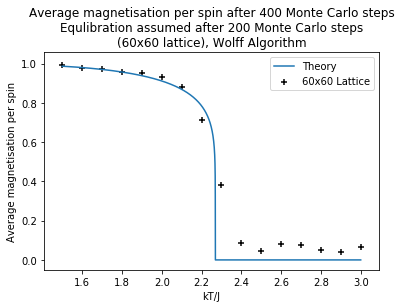

In [7]:
# Compare theory with simulation (magnetization vs temperature)

def predict_m(BJ):
    # Onsager's solution
    numerator = (1 - (np.tanh(BJ)**2))**4
    denominator = 16 * (np.tanh(BJ)**4)
    result = (1 - (numerator / denominator))
    if result < 0:
        result = 0
    result = result**(1/8)
    return result

# Generate input values
kT_linspace = np.linspace(kT_list.min(), kT_list.max(), 10000)
BJ_list = (J * np.ones(len(kT_linspace))) / kT_linspace

# generate predicted values
predictions = np.zeros(len(BJ_list))
for i in range(len(BJ_list)):
    predictions[i] = predict_m(BJ_list[i])

# Plot results vs predictions
plt.figure(figsize=(6, 4))
plt.plot(kT_linspace, predictions, label='Theory')
plt.scatter(kT_list, m_results, marker='+', c='black', label='60x60 Lattice')
plt.xlabel('kT/J')
plt.ylabel('Average magnetisation per spin')
plt.legend(loc='upper right')

plt.title('Average magnetisation per spin after ' + str(mc_steps)
          + ' Monte Carlo steps\nEqulibration assumed after ' + str(int(mc_steps/2))
          + ' Monte Carlo steps\n(60x60 lattice), Wolff Algorithm')
plt.show()


A phase transition is seen at kT/J ~ 2.3 as expected.

# Conway's game of life

The Lattice class structure and methods used above can also be used to implement cellular automata, e.g. Conway's Game of Life (https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life), which also runs on a square grid with periodic boundary conditions.

The canonical 'rules' define neighbours according to the Moore neighbourhood (all 8 neighbouring squares) as opposed to the von Neumann neighbourhood implemented in SquareLattice and used in the Ising model above, but this is easily remedied by defining another Lattice subclass (SquareLattice2). The game itself is then easy to implement (the below may not be the most compuationally efficient but is easily readable). The file game_of_life.py randomly initialises a game and animates its evoltuion indefinitely. 

In [8]:
class SquareLattice2(Lattice):
    def __init__(self, n, m):
        """ Moore neighbourhood.

        Args:
            n (int): linear size in y dimension
            m (int): linear size in x dimension
        """
        self.n_neighbours = 8
        super().__init__(n, m)

    def neighbours(self, i, j):
        """Nearest neighbouring sites (Moore neighbourhood).

        this function defines a square lattice:
              X X X
              X 0 X
              X X X

        Args:
            i, j (int): original lattice site

        Returns:
             nn (ndarray): array with entries corresponding to the eight nearest
             neighbours of the given lattice site.
        """
        n = self.n
        m = self.m
        nn = np.zeros([8, 2], dtype=np.int)

        # order: top, left, right, bottom
        nn[0, :] = np.mod(i + 1, n), np.mod(j - 1 + m, m)
        nn[1, :] = np.mod(i + 1, n), j
        nn[2, :] = np.mod(i + 1, n), np.mod(j + 1, m)
        nn[3, :] = i, np.mod(j - 1 + m, m)
        nn[4, :] = i, np.mod(j + 1, m)
        nn[5, :] = np.mod(i - 1 + n, n), np.mod(j - 1 + m, m)
        nn[6, :] = np.mod(i - 1 + n, n), j
        nn[7, :] = np.mod(i - 1 + n, n), np.mod(j + 1, m)

        return nn


class GameOfLife:
    def __init__(self, n, m, lattice_type=SquareLattice2):
        """ Conway's Game of Life

        Args:
            n (int): size y
            m (int): size x
            lattice_type: valid lattice subclass, default = SquareLattice2

        """

        self.n, self.m = n, m
        self.lattice = lattice_type(n, m)
        self.state = np.random.randint(
            0, 2, self.n * self.m).reshape([self.n, self.m])

    def evolve_one_step(self):
        """Updates game by one step according to canonical rules - from wikipedia:

        'Any live cell with fewer than two live neighbors dies, as if by under population.
        Any live cell with two or three live neighbors lives on to the next generation.
        Any live cell with more than three live neighbors dies, as if by overpopulation.
        Any dead cell with exactly three live neighbors becomes a live cell, as if by reproduction.'
        https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life

        """
        new_state = np.zeros([self.n, self.m])  # default = dead

        for k in range(self.n * self.m):
            i, j = self.lattice.single_to_double_index(k)
            live_neighbours = 0

            for nind in range(self.lattice.n_neighbours):
                p, q = self.lattice.neighbour_list[i, j, nind, :]
                live_neighbours += self.state[p, q]

            if self.state[i, j] == 0 and live_neighbours == 3:
                new_state[i, j] = 1
            elif self.state[i, j] == 1 and (
                    live_neighbours == 2 or live_neighbours == 3):
                new_state[i, j] = 1

        self.state = new_state


See animation/game_of_life.gif for an example generated using game_of_life.py